In [1]:
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import vice
from scipy.optimize import curve_fit
from astropy.io import fits
import seaborn as sns

In [3]:
import surp.analysis.gas_phase_data as gap
import surp.analysis.plotting_utils as pluto
import surp.analysis.apogee_analysis as aah
from surp.analysis.vice_model import vice_model

import arya

modified solar abundances via mag++22


# Stars

In [4]:
amarsi19 = pd.read_csv("../../data/amarsi_19.tsv", delimiter="\t *", comment="#", skiprows=[62, 63],)
amarsi19["[o/h]"] = amarsi19["[O/H]3N"]
amarsi19["[c/h]"] = amarsi19["[C/H]3N"]
amarsi19["[c/o]"] = amarsi19["[c/h]"] - amarsi19["[o/h]"] 

amarsi19["[o/h]_err"] = amarsi19["e_[O/H]3N"]
amarsi19["[c/h]_err"] = amarsi19["e_[C/H]3N"]
amarsi19["[c/o]_err"] = amarsi19["[o/h]_err"] + amarsi19["[c/h]_err"] 
amarsi19["[o/fe]"] = -amarsi19["[Fe/H]3L"] + amarsi19["[o/h]"]
amarsi19_sun = amarsi19.iloc[151]
amarsi19.drop(index=151, inplace=True)

/tmp/slurmtmp.24083366/ipykernel_108292/3998613471.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  amarsi19 = pd.read_csv("../../data/amarsi_19.tsv", delimiter="\t *", comment="#", skiprows=[62, 63],)


- \[Fe/H\]3L      7.4962
- C/H\]1N       8.4333
- \[O/H\]3N       8.6754

Amarsi is a reanalysis of nissen 2014 and nissen 2007, uses nlte 3d models

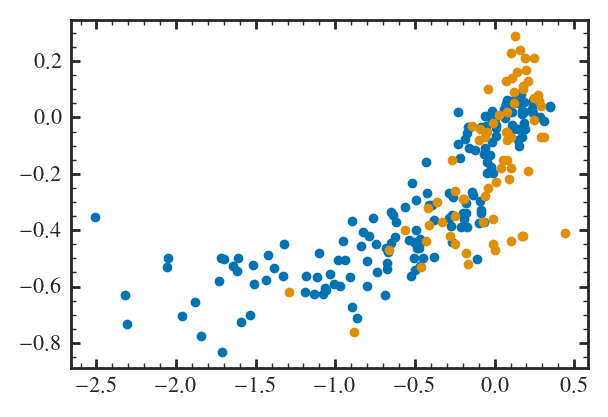

In [8]:
plt.scatter(amarsi19["[o/h]"], amarsi19["[c/o]"])
plt.scatter(bensby["[o/h]"], bensby["[c/o]"])

In [5]:
b18 = pd.read_csv("../../data/bedell18.dat", delimiter=" +", comment="#")

/tmp/slurmtmp.24168533/ipykernel_200877/4021858249.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  b18 = pd.read_csv("../../data/bedell18.dat", delimiter=" +", comment="#")


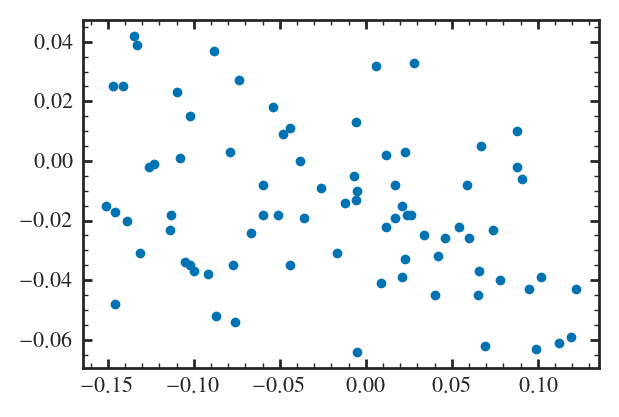

In [6]:
plt.scatter(b18["[OI/H]"], b18["[CI/H]"] - b18["[OI/H]"])

In [5]:
dm21 = pd.read_csv("../../data/dm21.csv", delimiter="\t *", comment="#")
dm21["[o/h]"] = dm21["[O1/Fe]"] + dm21["[Fe/H]"]
dm21["[c/o]"] = dm21["[C/O1]"]

/tmp/slurmtmp.24083366/ipykernel_108292/1036616196.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  dm21 = pd.read_csv("../../data/dm21.csv", delimiter="\t *", comment="#")


NameError: name 'bensby' is not defined

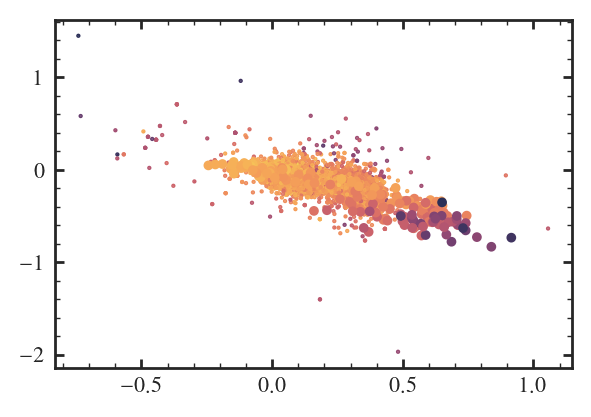

In [6]:
plt.scatter(amarsi19["[o/fe]"], amarsi19["[c/o]"], c=amarsi19["[o/h]"], clim=(-2.5, 0.5))
# arya.medianplot(aah.subgiants, x="MG_FE", y="C_MG", errorbar=None)
plt.scatter(aah.subgiants.MG_FE, aah.subgiants.C_MG, zorder=-1, s=0.3, c=aah.subgiants.MG_H)
plt.scatter(bensby["[o/fe]"], bensby["[c/o]"], c=bensby["[O/H]"], marker="*")
plt.colorbar()
plt.xlabel("[O/Fe]")
plt.ylabel("[C/O]")
plt.gca().invert_xaxis()
plt.plot([-1, 1], [1, -1])
plt.ylim(-1, 0.5)
plt.xlim(1, -0.5)

In [7]:
bensby21 = pd.read_csv("../../data/bensby21.tsv", delimiter="\t *", comment="#",)
bensby19 = pd.read_csv("../../data/bensby19.tsv", delimiter="\t *", comment="#",)

bensby = bensby21.set_index("Name").join(bensby19.set_index("Name"),rsuffix="_b19", how="left")

bensby["[c/o]"] = bensby["[C/H]"] - bensby["[O/H]"]
bensby["[o/fe]"] = bensby["[O/H]"] - bensby["[Fe/H]"]
bensby["[o/h]"] = bensby["[O/H]"]
bensby["[c/o]_err"] = bensby["e_[C/O]"]
bensby["[o/h]_err"] = bensby["e_[O/H]"]

/tmp/slurmtmp.24083366/ipykernel_108292/2535395439.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  bensby21 = pd.read_csv("../../data/bensby21.tsv", delimiter="\t *", comment="#",)
/tmp/slurmtmp.24083366/ipykernel_108292/2535395439.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  bensby19 = pd.read_csv("../../data/bensby19.tsv", delimiter="\t *", comment="#",)


/users/PAS2232/aeyobd/arya/arya/plotting/binnedplot.py:76: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for _, g in self.data.groupby(self.group_cols):
/users/PAS2232/aeyobd/arya/arya/plotting/binnedplot.py:76: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for _, g in self.data.groupby(self.group_cols):
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


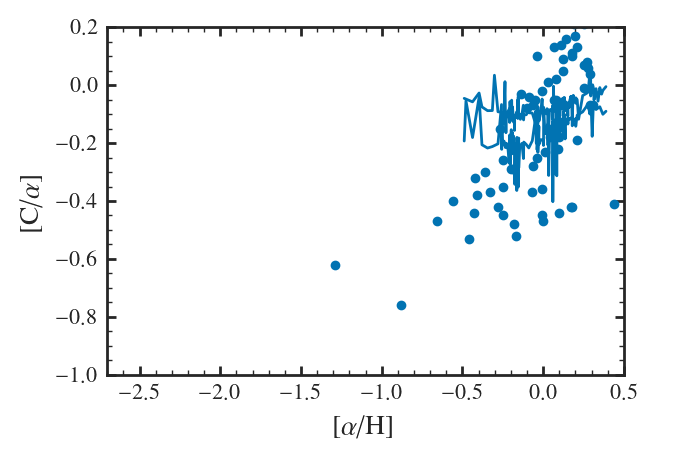

In [33]:
plt.xlim(-2.7, 0.5)

df = aah.subgiants
df["ha_lab"] = np.where(df.high_alpha, "subgiant, high-$\\alpha$", "subgiants, low-$\\alpha$")
arya.binnedplot(aah.subgiants, x="MG_H", y="C_MG", hue="ha_lab", errorbar=None, zorder=-1, aes="line", binrange=(-0.5, 0.4), hue_label=["high", "low"], stat="median")
# sns.scatterplot(amarsi19, x= "[O/H]", y="[C/O]", hue="Pop")

plt.scatter(bensby["[O/H]"], bensby["[c/o]"])
arya.Legend(loc=-1)
plt.ylim(-1, 0.2)
plt.xlabel("[$\\alpha$/H]")
plt.ylabel("[C/$\\alpha$]")

plt.savefig("amarsi_19.pdf")

In [34]:
berg19 = pd.read_csv("../../data/berg19.csv")
berg19 = berg19.iloc[:-1]
berg19["[c/o]"] = berg19.log_c_o + np.log10(12/16) - np.log10(vice.solar_z("c")/vice.solar_z("o"))
berg19["[o/h]"] = berg19.eps_o + np.log10(16) - np.log10(vice.solar_z("o")) - 12
berg19["[c/o]_err"] = berg19.log_c_o_err
berg19["[o/h]_err"] = berg19.eps_o_err

Below this is Lya, compilation of : a1: Cooke et al. (2015); 2: Dutta et al. (2014); 3: Cooke et al. (2014);
4: Ellison et al. (2010); 5: Cooke et al. (2011b); 6: This work; 7: Pettini et al.
(2008); 8: Morrison et al. (2016); 9: Srianand et al. (2010); 10: Cooke et al.
(2012); 11: Dessauges-Zavadsky et al. (2003)

In [21]:
cooke17 = pd.read_csv("../../data/cooke17.csv")

cooke17["[c/o]"] = cooke17.c_o
cooke17["[c/o]_err"] = cooke17.c_o_err
cooke17["[o/h]"] = cooke17.o_h
cooke17["[o/h]_err"] = cooke17.o_h_err


In [36]:
RL = pd.read_csv("../../data/extragalactic_RL.csv", sep="\t+")
RL["[c/o]"] = aah.log_to_bracket(RL.eps_c - RL.eps_o, "c", "o")
RL["[o/h]"] = aah.log_to_bracket(RL.eps_o, "o") - 12
RL["[c/o]_err"] = RL.c_err + RL.o_err
RL["[o/h]_err"] = RL.o_err 

/tmp/slurmtmp.24083366/ipykernel_67485/1624278178.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  RL = pd.read_csv("../../data/extragalactic_RL.csv", sep="\t+")


In [39]:
fiducial = vice_model("../../out/C11_f0.2.json")

In [15]:
flf21 = pd.read_csv("../../data/FLF21.csv", delimiter="\s+", comment="#")
flf21["[o/h]"] = flf21["[O/Fe]"] + flf21["[Fe/H]"]
flf21["[c/o]"] = flf21["[C/Fe]"] - flf21["[O/Fe]"]

# NOT COMPARABLE SAMPLE< HAS GIANTZ

In [41]:
F09 = pd.read_csv("../../data/Fabbian09.csv", sep="\s+")

Redshift: (Pettini et al. 2000;
Fosbury & Villar-Martín et al. 2003; Erb et al. 2010; Christensen
et al. 2012; Bayliss et al. 2014; James et al. 2014; Stark et al.
2014; Steidel et al. 2016; Vanzella et al. 2016; Amorín et al.
2017; Berg et al. 2018; Rigby et al. 2018)

RL: (teal squares: Esteban et al. 2002, 2009,
2014; Pilyugin & Thuan 2005; García-Rojas & Esteban 2007;
López-Sánchez et al. 2007).

CL: Senchyna et al. (2017) and Peña-Guerrero et al. (2017)

MW stars: Gustafsson et al. (1999), Akerman
et al. (2004), Fabbian et al. (2009), and Nissen et al. (2014)

In [68]:
all_abundances = pd.DataFrame(columns=["[c/o]", "[c/o]_err", "[o/h]", "[o/h]_err", "type"])


for df, label in [(RL, "RL"), (berg19, "dwarf"), (gap.read_skillman20(), "RL"), (gap.read_md22(), "RL"), 
                  (cooke17, "DLA"), (amarsi19, "star"), (bensby, "star")]:
    all_abundances = pd.concat([
        all_abundances, 
        pd.DataFrame({
        "[c/o]": df["[c/o]"],
        "[c/o]_err": df["[c/o]_err"],
        "[o/h]": df["[o/h]"],
        "[o/h]_err": df["[o/h]_err"],
        "type": [label]*len(df)
    })], ignore_index=True)


In [69]:
all_abundances.to_csv("all_data.csv")

In [51]:
subgiants = aah.subgiants
filt = ~np.isnan(subgiants["C_MG"])
filt &= ~np.isnan(subgiants["MG_H"])
filt &= subgiants["high_alpha"]
subgiants = subgiants[filt]

/tmp/slurmtmp.24083366/ipykernel_67485/3371328301.py:27: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  leg.legendHandles[-1].set_sizes([16])
/tmp/slurmtmp.24083366/ipykernel_67485/3371328301.py:28: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  leg.legendHandles[-1].set_alpha(1)


AttributeError: 'Subplot' object has no attribute 'save'

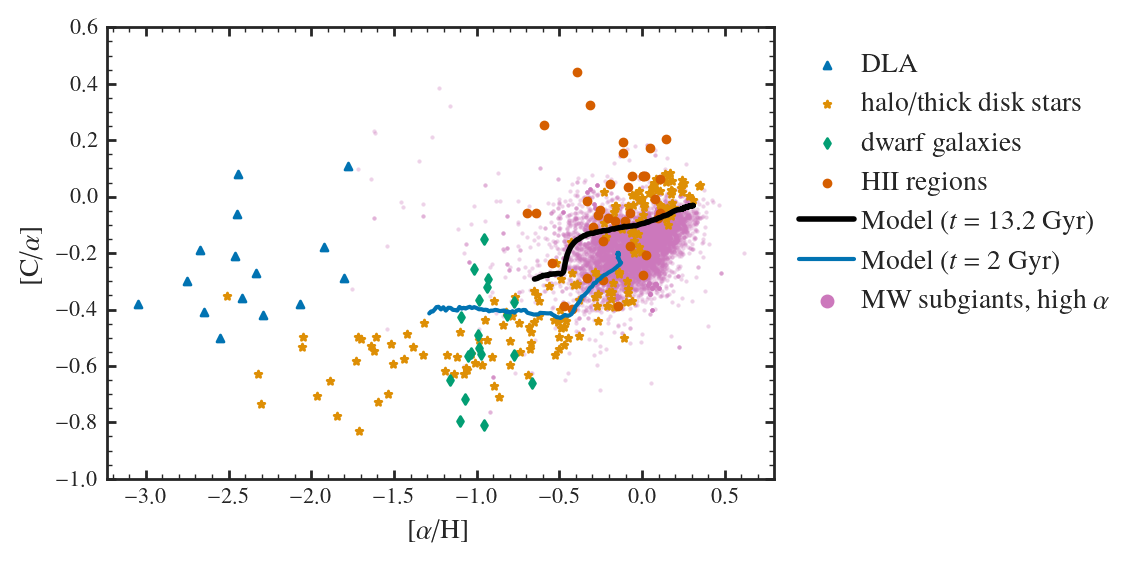

In [55]:
arya.style.set_size((4, 2*np.sqrt(2)))
sp = arya.Subplot()

for i in [3,2,1,0]:
    label = ["HII regions", "dwarf galaxies", "halo/thick disk stars", "DLA"][i]
    val = ["RL", "dwarf", "star", "DLA"][i]
    df = all_abundances[all_abundances.type == val]
    plt.scatter(df["[o/h]"], df["[c/o]"], label=label,
               marker=["o", "d", "*", "^"][i])
    
    
fiducial.plot_gas("[o/h]", "[c/o]", label="Model ($t=13.2$ Gyr)", plot_data=False, color="k", zorder=3, lw=2)

fiducial.plot_annulus_at_t("[o/h]", "[c/o]", t=2, label="Model ($t=2$ Gyr)", zorder=3, lw=1.5)


ha = subgiants["high_alpha"]
df = subgiants[ha]
plt.scatter(df["MG_H"], df["C_MG"], s=0.3, alpha=0.3, zorder=-1, label="MW subgiants, high $\\alpha$")

plt.ylim(-1, 0.6)

plt.xlabel(r"[$\alpha$/H]")
plt.ylabel(r"[C/$\alpha$]")

leg = pluto.legend_outside()
leg.legendHandles[-1].set_sizes([16])
leg.legendHandles[-1].set_alpha(1)
sp.save("summary.pdf")

In [ ]:
plt.figure(figsize=(10, 5))

plt.scatter(N14["[O/H]3n"], N14["[C/H]n"]-N14["[O/H]3n"], marker="*", label="Halo/Thick Disk")
plt.scatter(F09.oh, F09.co, label="F+09", marker="*")
# plt.scatter(subgiants["O_H"], subgiants["C_O"], s=0.1, alpha=0.1, color="k", zorder=-2)

ha = subgiants["high_alpha"]
df = subgiants[ha]
plt.scatter(df["MG_H"], df["C_MG"], s=0.1, alpha=0.3, zorder=-1, label="subgiants, high $\\alpha$")
df = subgiants[~ha]
plt.scatter(df["MG_H"], df["C_MG"], s=0.1, alpha=0.3, zorder=-2, label="subgiants, low $\\alpha$")

plt.ylim(-0.8, 0.2)
plt.xlabel(r"[$\alpha$/H]")
plt.ylabel(r"[C/$\alpha$]")
pluto.legend_outside()
plt.gca().set_aspect("equal")
sf("high_alpha_halo")

NameError: name 'sf' is not defined

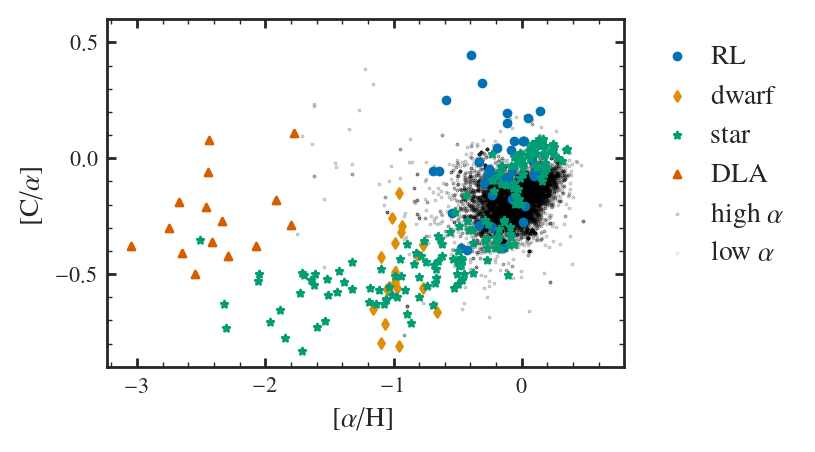

In [56]:
for i in range(4):
    val = ["RL", "dwarf", "star", "DLA"][i]
    df = all_abundances[all_abundances.type == val]
    plt.scatter(df["[o/h]"], df["[c/o]"], label=val,
               marker=["o", "d", "*", "^"][i])
    
ha = subgiants["high_alpha"]
df = subgiants[ha]
plt.scatter(df["MG_H"], df["C_MG"], s=0.1, alpha=0.3, color="k", zorder=-2, label="high $\\alpha$")

df = subgiants[~ha]
plt.scatter(df["MG_H"], df["C_MG"], s=0.1, alpha=0.3, color="y", zorder=-3, label="low $\\alpha$")

plt.ylim(-0.9, 0.6)
plt.xlabel(r"[$\alpha$/H]")
plt.ylabel(r"[C/$\alpha$]")
pluto.legend_outside()

sf("summary_high_low_a")

In [ ]:
pluto.err_scatter(RL.eps_o - RL.eps_fe, RL["[c/o]"], RL["[c/o]_err"], RL.o_err + RL.fe_err)

In [ ]:
N14.columns

In [57]:
o_0 = -0.2

filt = N14["[O/H]3"] < 0.05 + o_0
filt &= N14["[O/H]3"] > -0.05 + o_0
df = N14[filt]

pluto.err_scatter(df["[O/H]3"] - df["[Fe/H]"], df["[c/o]"])

aah.plot_coofe(o_0)

NameError: name 'N14' is not defined

In [58]:
aah.plot_coofe?

Signature: aah.plot_coofe(c=-0.1, w=0.05, s=1, alpha=0.1, color='black', **kwargs)
Docstring: <no docstring>
File:      ~/surp/surp/analysis/apogee_analysis.py
Type:      function

In [59]:

df = N14

pluto.err_scatter(df["[O/H]3"] - df["[Fe/H]"], df["[c/o]"])
aah.plot_coofe(w=10)
plt.xlim(-0.2, 0.8)
plt.ylim(-0.8, 0.3)

plt.xlim("[$\\alpha)

SyntaxError: EOL while scanning string literal (3673129111.py, line 8)

In [60]:
plt.hist(N14["[O/H]3"])

NameError: name 'N14' is not defined

In [61]:
sum(N14["[O/H]3"] != 0)

NameError: name 'N14' is not defined

/users/PAS2232/aeyobd/surp/surp/analysis/apogee_analysis.py:190: FutureWarning: Could not cast to float64, falling back to object. This behavior is deprecated. In a future version, when a dtype is passed to 'DataFrame', either all columns will be cast to that dtype, or a TypeError will be raised.
  return pd.DataFrame(df, dtype=float)


(-0.5, 0.5)

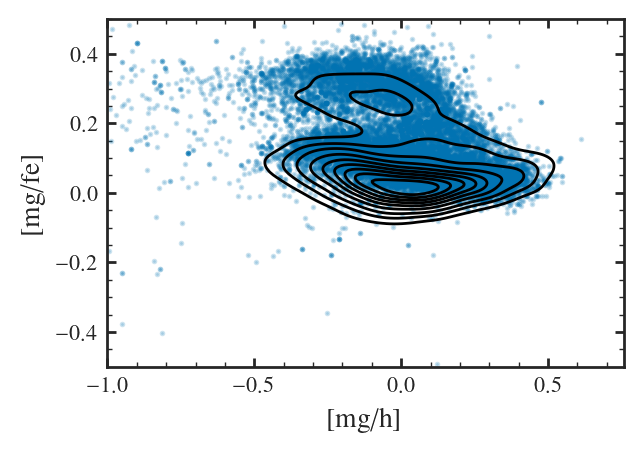

In [62]:
df = aah.subgiants

plt.scatter(df["MG_H"], df["MG_FE"], s=1, alpha=0.2)

aah.plot_v21_contour("[mg/h]", "[mg/fe]", exclude_high_alpha=False)
plt.xlim(-1)
plt.ylim(-0.5, 0.5)

In [63]:
v21 = aah.vincenzo2021()

/users/PAS2232/aeyobd/surp/surp/analysis/apogee_analysis.py:190: FutureWarning: Could not cast to float64, falling back to object. This behavior is deprecated. In a future version, when a dtype is passed to 'DataFrame', either all columns will be cast to that dtype, or a TypeError will be raised.
  return pd.DataFrame(df, dtype=float)


(array([5.11569758e-04, 2.55784879e-04, 2.55784879e-04, 7.67354637e-04,
        0.00000000e+00, 2.04627903e-03, 4.09255806e-03, 4.09255806e-03,
        7.41776149e-03, 7.16197661e-03, 1.17661044e-02, 1.99512205e-02,
        2.45553484e-02, 8.74784286e-02, 5.36380891e-01, 1.34798631e+00,
        1.88411142e+00, 1.39888750e+00, 5.01594147e-01, 2.37879937e-02]),
 array([-2.79775715, -2.62719894, -2.45664073, -2.28608252, -2.11552432,
        -1.94496611, -1.7744079 , -1.60384969, -1.43329148, -1.26273327,
        -1.09217507, -0.92161686, -0.75105865, -0.58050044, -0.40994223,
        -0.23938403, -0.06882582,  0.10173239,  0.2722906 ,  0.44284881,
         0.61340702]),
 [<matplotlib.patches.Polygon at 0x2b9b63f97a90>])

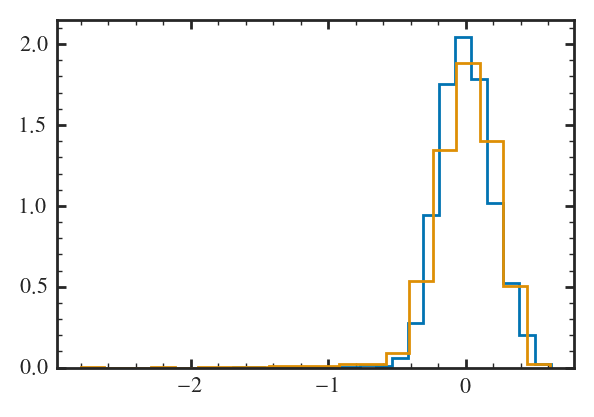

In [64]:
plt.hist(v21["[mg/h]"], histtype="step", bins=20, density=True)
plt.hist(aah.subgiants["MG_H"], histtype="step", bins=20, density=True)